In [15]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import  GradientBoostingClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV,GridSearchCV,cross_val_score, learning_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from hyperopt import fmin, tpe,hp, Trials
from sklearn.ensemble import StackingClassifier
import warnings
warnings.filterwarnings('ignore')

In [2]:
school_df = pd.read_csv('../week 4 Task/updated_data.csv', index_col=0)
X = school_df.drop('Target_encoded', axis=1)
y = school_df['Target_encoded']

In [3]:
X_train , X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y, random_state=42)

## GridSearchCv

In [4]:
def gridsearch(model, params,):
    gridsearch = GridSearchCV(estimator=model,param_grid=params,cv=10,n_jobs=1)
    gridsearch.fit(X_train,y_train)
    train_pred = gridsearch.predict(X_train)
    test_pred = gridsearch.predict(X_test)
    model_pred_proba=gridsearch.predict_proba(X_test)[:,1]
    print('training accuracy: ',accuracy_score(train_pred,y_train))
    print('testing accuracy: ',accuracy_score(test_pred,y_test))
    scores = cross_val_score(gridsearch, X_train, y_train, cv=10)  # 10-fold cross-validation
    print("Mean cross-validation score:", np.mean(scores))
    print('roc_auc: ', roc_auc_score(y_test,model_pred_proba))
    print("Confusion matrix:\n", confusion_matrix(y_test, test_pred))
    print("Classification report:\n", classification_report(y_test, test_pred))

## RandomizedSearchCV

In [5]:
def randomizedsearch(model, params,):
    randomsearch = RandomizedSearchCV(model,params, n_iter=100,
    scoring='accuracy',
    cv=10,
    random_state=42,
    n_jobs=-1)
    randomsearch.fit(X_train,y_train)
    train_pred = randomsearch.predict(X_train)
    test_pred = randomsearch.predict(X_test)
    model_pred_proba=randomsearch.predict_proba(X_test)[:,1]
    print('training accuracy: ',accuracy_score(train_pred,y_train))
    print('testing accuracy: ',accuracy_score(test_pred,y_test))
    scores = cross_val_score(randomsearch, X_train, y_train, cv=10)  # 10-fold cross-validation
    print("Mean cross-validation score:", np.mean(scores))
    print('roc_auc: ', roc_auc_score(y_test,model_pred_proba))
    print("Confusion matrix:\n", confusion_matrix(y_test, test_pred))
    print("Classification report:\n", classification_report(y_test, test_pred))

## Hyperopt

In [38]:
def hyperopt(model,params):
    mdl = model.set_params(**params)
    mdl.fit(X_train, y_train.astype(str))
    train_pred = mdl.predict(X_train)
    test_pred = mdl.predict(X_test)
    model_pred_proba=mdl.predict_proba(X_test)[:,1]
    print('training accuracy: ',accuracy_score(train_pred,y_train))
    print('testing accuracy: ',accuracy_score(test_pred,y_test))
    scores = cross_val_score(mdl, X_train, y_train.astype(str), cv=10)  # 10-fold cross-validation
    print("Mean cross-validation score:", np.mean(scores))
    print('roc_auc: ', roc_auc_score(y_test,model_pred_proba))
    print("Confusion matrix:\n", confusion_matrix(y_test, test_pred))
    print("Classification report:\n", classification_report(y_test, test_pred))


In [ ]:
def plot_learning_curve(model):
    train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=10, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01,1,50), verbose=1)
   
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label="Training scores")
    plt.plot(train_sizes, test_mean, label="Testing scores")

    plt.title(f'{model} Learning curve')
    plt.xlabel('Training size')
    plt.ylabel('Accuracy score')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

## Logistic Regression

In [6]:
params_logreg ={
    'penalty':['l1', 'l2', None],
    'multi_class':['auto', 'ovr', 'multinomial'],
    'C':np.arange(0.001,0.1),
    'solver':['lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
}
logreg = LogisticRegression()
randomizedsearch(logreg, params_logreg)

training accuracy:  0.8612602430064991
testing accuracy:  0.8779661016949153
Mean cross-validation score: 0.8598509947023896
roc_auc:  0.9066344824353777
Confusion matrix:
 [[567  34]
 [ 74 210]]
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91       601
           1       0.86      0.74      0.80       284

    accuracy                           0.88       885
   macro avg       0.87      0.84      0.85       885
weighted avg       0.88      0.88      0.88       885



In [7]:
gridsearch(logreg, params_logreg)
plot_learning_curve(logreg)

training accuracy:  0.8612602430064991
testing accuracy:  0.8779661016949153
Mean cross-validation score: 0.8598509947023896
roc_auc:  0.9066344824353777
Confusion matrix:
 [[567  34]
 [ 74 210]]
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91       601
           1       0.86      0.74      0.80       284

    accuracy                           0.88       885
   macro avg       0.87      0.84      0.85       885
weighted avg       0.88      0.88      0.88       885



In [40]:

space = {
    'penalty':hp.choice(['l1', 'l2', None]),
    'multi_class':hp.choice('multi_class',['auto', 'ovr', 'multinomial']),
    'C':hp.choice(np.arange(0.001,0.1)),
    'solver':hp.choice('solver',['lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga'])
}
trials =Trials()
best = fmin(fn=lambda params: hyperopt(logreg,params), space=space, algo=tpe.suggest,max_evals=50)

TypeError: require string label

## Decision Tree Classifier

In [ ]:
dt = DecisionTreeClassifier()
# Checking for the best parameters
params_dt ={
    'criterion':['gini', 'entropy', 'log_loss'],
    'max_features':['sqrt', 'log2', None],
    'max_depth':np.arange(1,10,1),
    'class_weight':['balanced', 'balanced_subsample']
}

randomizedsearch(dt, params_dt)

In [ ]:
gridsearch(dt, params_dt)
plot_learning_curve(dt)

In [16]:

space = {
    'criterion':hp.quniform('criterion',['gini', 'entropy', 'log_loss']),
    'max_features':hp.uniform('max_features',['sqrt', 'log2', None]),
    'max_depth':hp.quniform('max_depth',[1,2,3,4,5]),
    'class_weight':hp.quniform('class_weight',['balanced', 'balanced_subsample'])
}

# best = fmin(fn=lambda params: hyperopt(dt,params), space=space, algo=tpe.suggest,max_evals=50)

## Support Machine Vector

In [ ]:
svm = SVC()
# Checking for the best parameters
params_svm ={
    'kernel':['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
    'gamma':['scale', 'auto'],
   'C':np.arange(1,10,1),
    'class_weight':['dict','balanced']
}

randomizedsearch(svm, params_svm)


In [ ]:
gridsearch(svm, params_svm)
plot_learning_curve(svm)

In [ ]:
best = fmin(fn=lambda params: hyperopt(svm,params), space=space, algo=tpe.suggest,max_evals=50)

## Random Forest Classifier

In [ ]:
rf = RandomForestClassifier()
# Checking for the best parameters
params_rf ={
    'criterion':['gini', 'entropy', 'log_loss'],
    'max_features':['sqrt', 'log2', None],
    'max_depth':np.arange(1,10,1),
    'n_estimators':np.arange(100,1000,100),
    'class_weight':['balanced', 'balanced_subsample']
}
randomizedsearch(rf, params_rf)

In [ ]:
gridsearch(rf, params_rf)
plot_learning_curve(rf)

## Gradient Boosting Classifier

In [ ]:
gbt = GradientBoostingClassifier()
# Checking for the best parameters
params_gbt ={
    'subsample':np.arange(0.1,1),
    'max_features':['sqrt', 'log2', None],
    'max_depth':np.arange(1,10,1),
    'n_estimators':np.arange(100,1000,100)
}
randomizedsearch(gbt, params_gbt)

In [ ]:
gridsearch(gbt, params_gbt)
plot_learning_curve(gbt)

## Advanced Ensemble Method 

In [20]:
base_models = [
    ('dt', DecisionTreeClassifier( max_features=None,max_depth= 4,criterion='log_loss',class_weight='balanced', random_state=42)),  
    ('rf', RandomForestClassifier(n_estimators= 300,max_features='sqrt',max_depth= 9,criterion='gini',class_weight='balanced', random_state=42)),
    ('svm', SVC(kernel="linear", gamma='auto', C=2, random_state=42)),
    ('gb', GradientBoostingClassifier(subsample = 0.1, n_estimators= 700, max_features= 'sqrt', max_depth= 1, random_state=42))
]

# Define meta-model
meta_model = LogisticRegression(C = 0.001,max_iter=300, multi_class = 'auto', penalty = None, solver = 'newton-cg',random_state=42)

# Create the stacking classifier
stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5
)

# Fit the stacking model
stacking_model.fit(X_train, y_train)
train_pred =  stacking_model.predict(X_train)
test_pred = stacking_model.predict(X_test)
model_pred_proba= stacking_model.predict_proba(X_test)[:,1]
print('training accuracy: ',accuracy_score(train_pred,y_train))
print('testing accuracy: ',accuracy_score(test_pred,y_test))
scores = cross_val_score( stacking_model, X_train, y_train, cv=10)  # 10-fold cross-validation
print("Mean cross-validation score:", np.mean(scores))
print('roc_auc: ', roc_auc_score(y_test,model_pred_proba))
print("Confusion matrix:\n", confusion_matrix(y_test, test_pred))
print("Classification report:\n", classification_report(y_test, test_pred))


    

training accuracy:  0.907883582933032
testing accuracy:  0.8723163841807909
Mean cross-validation score: 0.8649349402218274
roc_auc:  0.9196995617632584
Confusion matrix:
 [[558  43]
 [ 70 214]]
Classification report:
               precision    recall  f1-score   support

           0       0.89      0.93      0.91       601
           1       0.83      0.75      0.79       284

    accuracy                           0.87       885
   macro avg       0.86      0.84      0.85       885
weighted avg       0.87      0.87      0.87       885



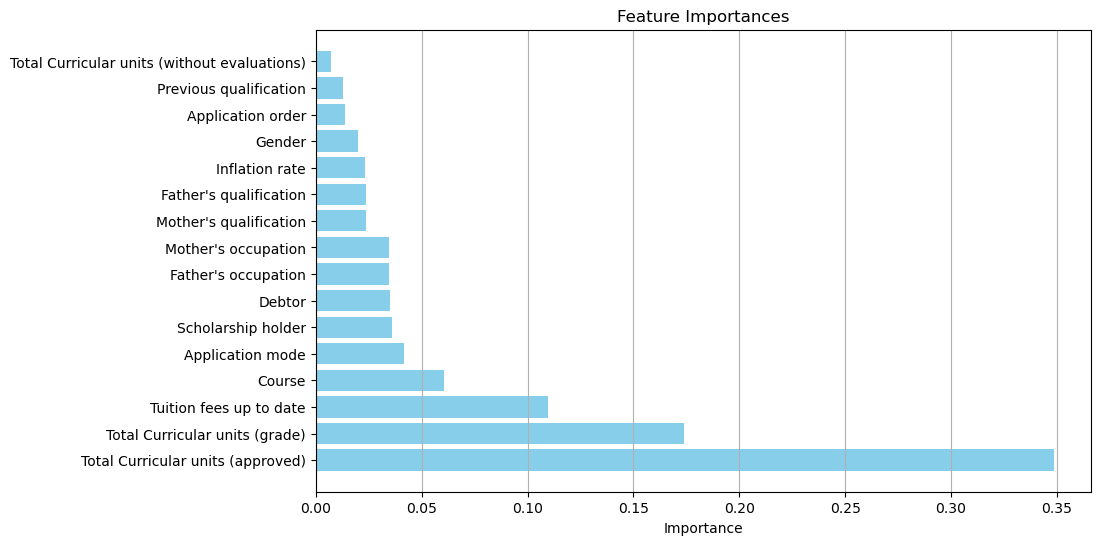

In [21]:
# Train a Random Forest model
model = RandomForestClassifier(n_estimators= 300,max_features='sqrt',max_depth= 9,criterion='gini',class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# Get feature importances
importances = model.feature_importances_
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.grid(axis='x')
plt.show()

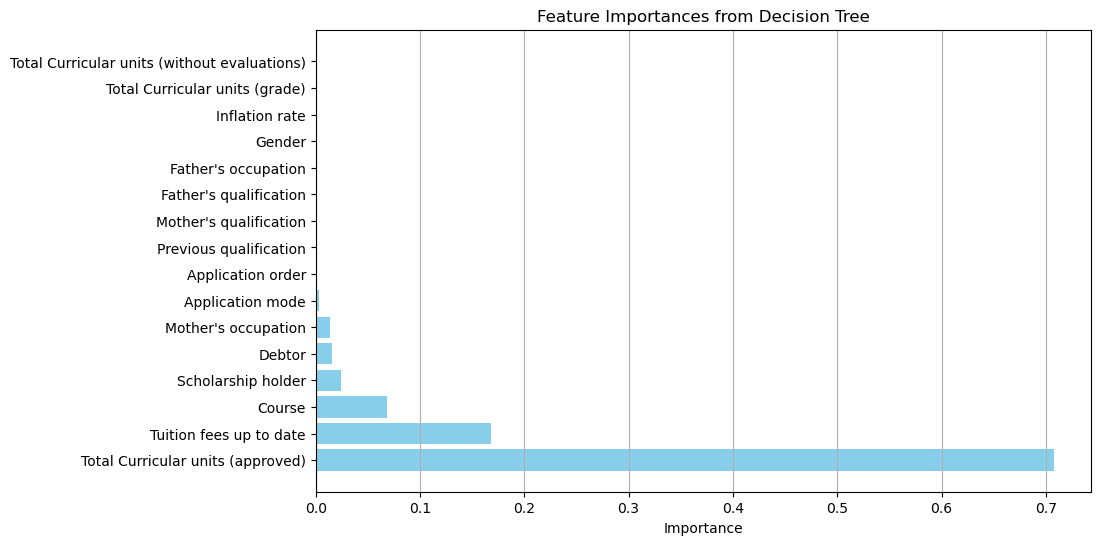

In [22]:
dt_model = DecisionTreeClassifier(max_features=None,max_depth= 4,criterion='log_loss',class_weight='balanced', random_state=42)
dt_model.fit(X_train, y_train)

# Get feature importances
importances = dt_model.feature_importances_
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances from Decision Tree')
plt.grid(axis='x')
plt.show()

## Shap (SHapley Additive exPlanations)  values

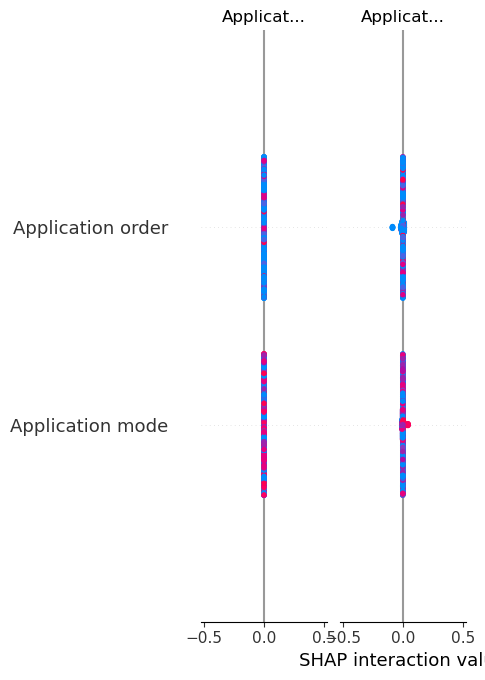

DimensionError: Length of features is not equal to the length of shap_values!

In [23]:
# Create SHAP explainer
import shap
explainer = shap.TreeExplainer(dt_model)
# Create SHAP explainer
explainer = shap.TreeExplainer(dt_model)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)

# Force plot for the first instance
shap.initjs()  # Initialize JavaScript visualization
shap.force_plot(explainer.expected_value[0], shap_values[0][0], X_test.iloc[0])

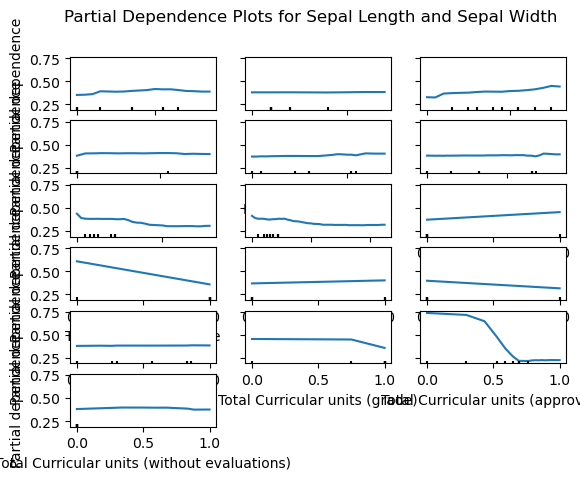

In [32]:
from sklearn.inspection import PartialDependenceDisplay

disp = PartialDependenceDisplay.from_estimator(model, X_train, features=X.columns, grid_resolution=50)
plt.suptitle('Partial Dependence Plots for Sepal Length and Sepal Width')
plt.show()

In [41]:
import pickle

# Save the stacking model
with open('stacking_model.pkl', 'wb') as f:
    pickle.dump(stacking_model, f)

# Save the best models
with open('best_logreg_model.pkl', 'wb') as f:
    pickle.dump(logreg, f)

with open('best_dt_model.pkl', 'wb') as f:
    pickle.dump(dt, f)

with open('best_svm_model.pkl', 'wb') as f:
    pickle.dump(svm, f)

with open('best_rf_model.pkl', 'wb') as f:
    pickle.dump(rf, f)

with open('best_gbt_model.pkl', 'wb') as f:
    pickle.dump(gbt, f)

print("Models saved successfully.")

NameError: name 'dt' is not defined